**Import libraries and define system parameters**

Selected number of sensors: 103


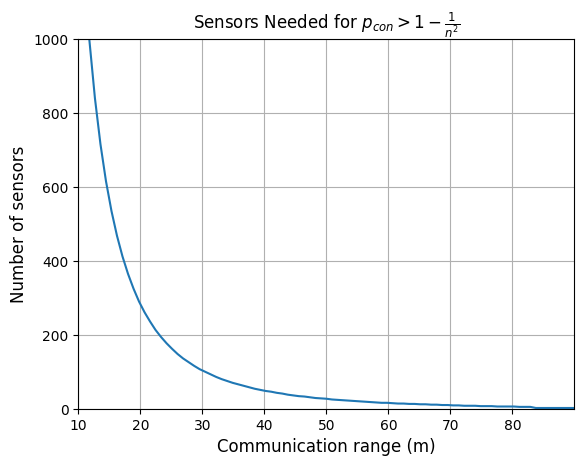

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from utils import calculate_num_sensors, calculate_graph_matrices, is_graph_connected, get_field_function, get_sensor_measurements, visualize_graphs
from utils import make_tl_plots, make_async_plots 
from randomized_gossip import get_W_bar, get_p_matrix, randomized_gossip
from pdmm import pdmm_average, pdmm_median

FIELD_SIZE = 100
FIELD_RANGE = np.array([[0, FIELD_SIZE], [0, FIELD_SIZE]])

# True measurement function
field_function = get_field_function()

# Plot communication range vs number of sensors needed for 
comm_range_vals = np.linspace(10, 90, 91)
num_sensor_vals = list(map(calculate_num_sensors, comm_range_vals, FIELD_SIZE*np.ones((100,)), 2*np.ones((100,))))
fig = plt.figure()
plt.rc('axes', labelsize=12)
plt.plot(comm_range_vals, num_sensor_vals)
plt.xlabel("Communication range (m)")
plt.ylabel("Number of sensors")
plt.title(r"Sensors Needed for $p_{con} > 1-\frac{1}{n^2}$")
plt.xlim([10, 90])
plt.ylim([0,1000])
plt.gca().set_xticks(np.arange(10,90,10))
plt.grid(True)
plt.rcParams['savefig.dpi'] = 600
fig.savefig("figures/num_sensors.png", bbox_inches='tight')

COMM_RANGE = 30
NUM_SENSORS = calculate_num_sensors(COMM_RANGE, FIELD_SIZE, 2)
print("Selected number of sensors:", NUM_SENSORS)

**Generate random graph**

The graph is connected.
Average temperature: 23.11 C


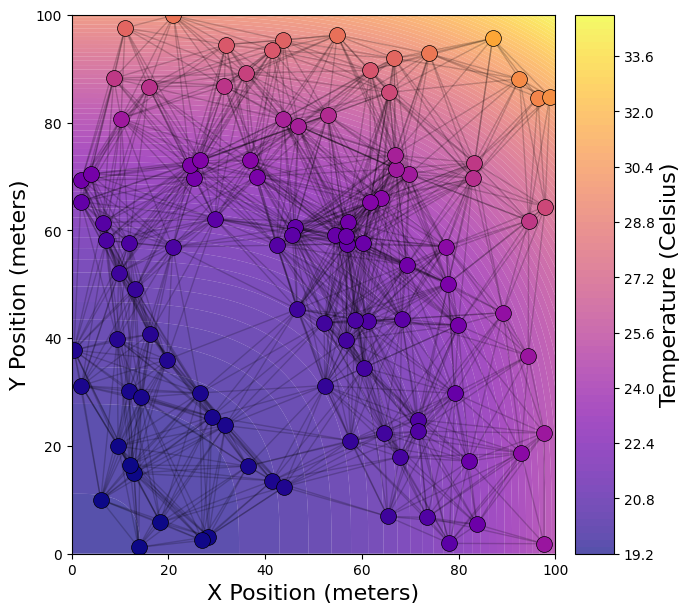

In [2]:
# Set random seed for reproducibiliy
np.random.seed(0)

# Randomly generate sensor locations within the field
sensor_locations = np.array([np.random.uniform(FIELD_RANGE[0,0], FIELD_RANGE[0,1], NUM_SENSORS),
                            np.random.uniform(FIELD_RANGE[1,0], FIELD_RANGE[1,1], NUM_SENSORS)])

# Calculate the adjacency matrix, degree matrix, and Laplacian matrix
adjacency_matrix, degree_matrix, laplacian_matrix = calculate_graph_matrices(sensor_locations, COMM_RANGE)
# Determine if the graph is connected
if not is_graph_connected(laplacian_matrix):
    print("Warning: The graph is not connected.")
else:
    print("The graph is connected.")

# Generate sensor measurements from the field function
noise_std = 0
sensor_measurements = get_sensor_measurements(sensor_locations, field_function, noise_std)
average_temperature = np.mean(sensor_measurements)
print("Average temperature:", "{:.2f}".format(average_temperature), "C")

# Visualize the sensor locations and the communication graph
visualize_graphs(sensor_locations, adjacency_matrix, field_function, sensor_measurements)

**Randomized Gossip - Get optimal P matrix and compare eigenvalues with natural P matrix** 

In [3]:
# Get the P and W_bar for both natural and optimized averaging
P_opt = get_p_matrix(adjacency_matrix)
P_nat = adjacency_matrix / np.sum(adjacency_matrix, axis=1, keepdims=True)
W_bar1 = get_W_bar(P_opt, adjacency_matrix)
W_bar2 = get_W_bar(P_nat, adjacency_matrix)

# Check that the optimized P matrix performs better
if (np.linalg.eigvalsh(W_bar1)[::-1][1] < np.linalg.eigvalsh(W_bar2)[::-1][1]):
    print("The optimal P matrix is better than the uniform distribution.")
else:
    print("The uniform distribution is better than the optimal P matrix.")

The optimal P matrix is better than the uniform distribution.


**Find the best value of c for PDMM average consensus**

Best c value is: 0.11


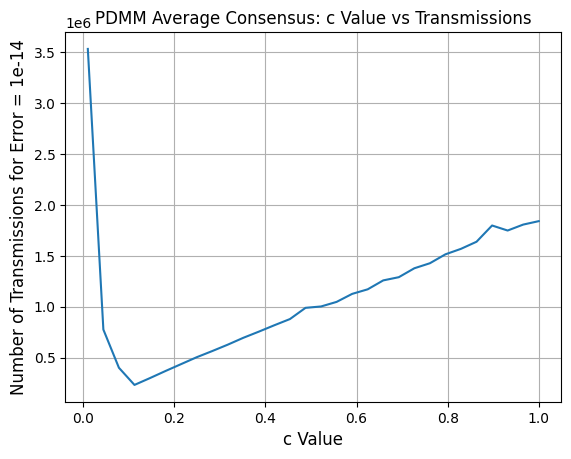

In [4]:
c_vals = np.linspace(0.01, 1, 30)
num_transmissions = []
for c in c_vals:
    error_vals, transmissions, x = pdmm_average(adjacency_matrix, sensor_measurements, c, broadcast=False)
    num_transmissions.append(transmissions[-1])
best_c = c_vals[np.argmin(num_transmissions)]
print("Best c value is:", np.round(best_c, 2))

fig = plt.figure()  
plt.rc('axes', labelsize=12)
plt.plot(c_vals, num_transmissions, label='Number of Transmissions')
plt.grid(True)
plt.xlabel("c Value")
plt.ylabel("Number of Transmissions for Error = 1e-14")
plt.title("PDMM Average Consensus: c Value vs Transmissions")
fig.savefig("figures/avg_cvalues.png", bbox_inches='tight')

**Plotting and comparing Randomized Gossip and PDMM**

32496 70226
233376 10712


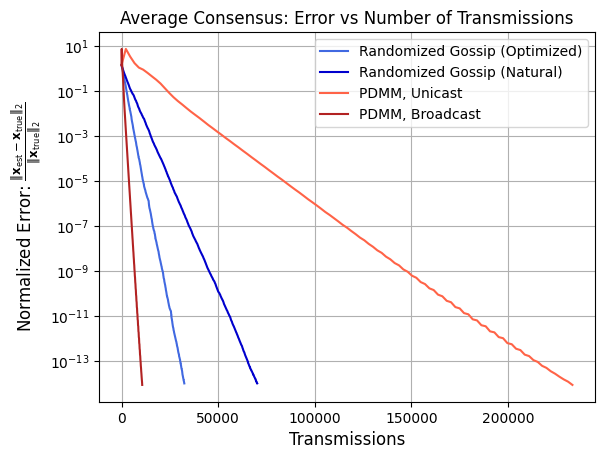

In [ ]:
# Run randomized gossip (natural and optimal)
error_vals_go, transmissions_go, x_go, Wk_error_go = randomized_gossip(adjacency_matrix, sensor_measurements, P_opt, calculate_Wk = True)
error_vals_gn, transmissions_gn, x_gn, Wk_error_gn = randomized_gossip(adjacency_matrix, sensor_measurements, P_nat, calculate_Wk = True)

# Run PDMM with both broadcast and unicast protocols
error_vals_pu, transmissions_pu, x_pu = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = False)
error_vals_pb, transmissions_pb, x_pb = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = True)

fig = plt.figure()

plt.semilogy(transmissions_go, error_vals_go, label=f'Randomized Gossip (Optimized)', color="royalblue")
plt.semilogy(transmissions_gn, error_vals_gn, label=f'Randomized Gossip (Natural)', color="mediumblue")
plt.semilogy(transmissions_pu, error_vals_pu, label=f'PDMM, Unicast', color="tomato")
plt.semilogy(transmissions_pb, error_vals_pb, label=f'PDMM, Broadcast', color="firebrick")

plt.grid(True)
plt.xlabel("Transmissions")
plt.ylabel("Normalized Error")
plt.title("Average Consensus: Error vs Number of Transmissions")
plt.legend()
fig.savefig("figures/avg_consensus.png", bbox_inches='tight')


**PDMM and Randomized Gossip with Transmission Loss**

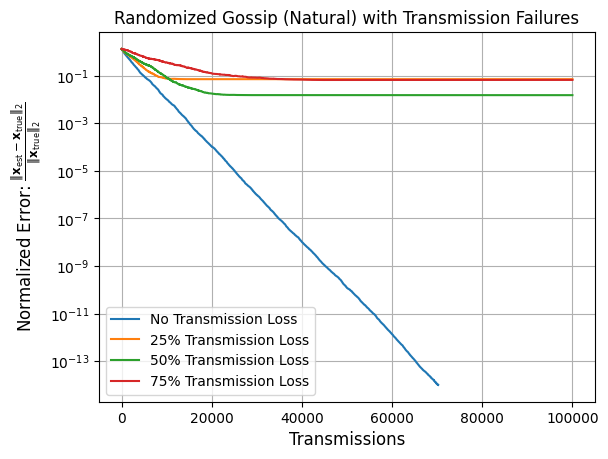

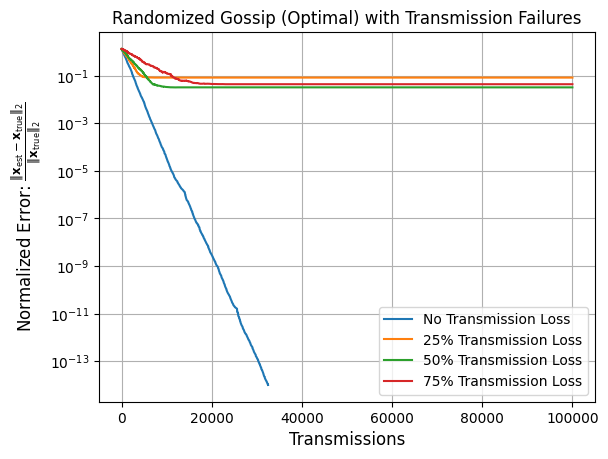

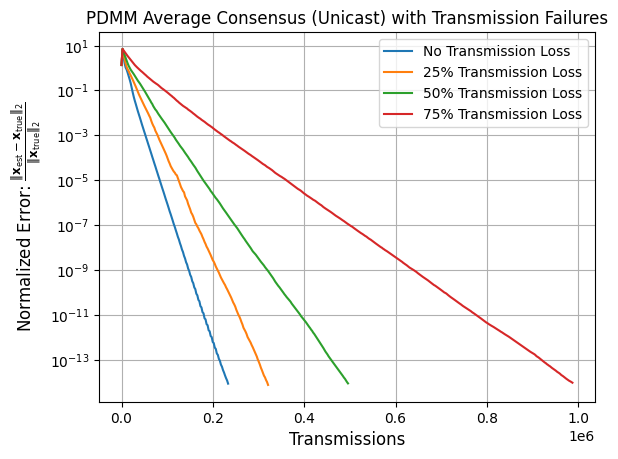

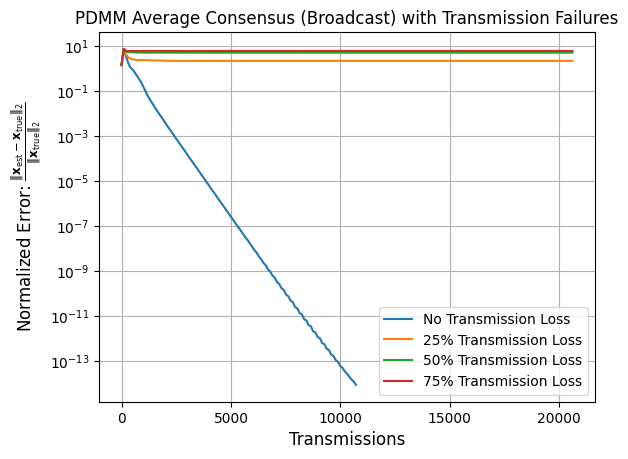

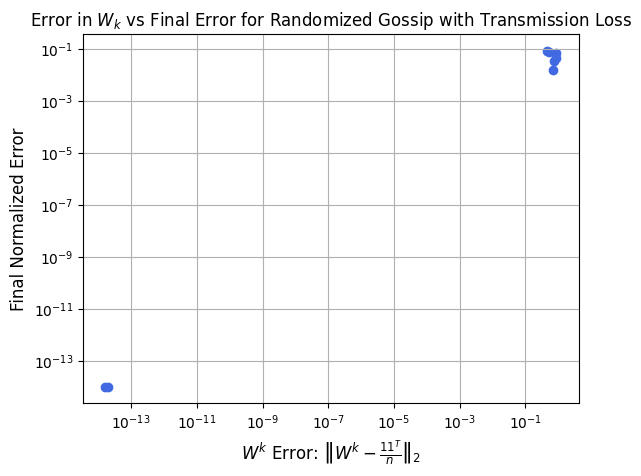

In [6]:
# Transmission loss - Gossip natural
error_vals_gn_tl25, transmissions_gn_tl25, _, Wk_error_gn_tl25 = randomized_gossip(adjacency_matrix, sensor_measurements, P_nat, transmission_loss=0.25, calculate_Wk = True)
error_vals_gn_tl50, transmissions_gn_tl50, _, Wk_error_gn_tl50 = randomized_gossip(adjacency_matrix, sensor_measurements, P_nat, transmission_loss=0.5, calculate_Wk = True)
error_vals_gn_tl75, transmissions_gn_tl75, _, Wk_error_gn_tl75 = randomized_gossip(adjacency_matrix, sensor_measurements, P_nat, transmission_loss=0.75, calculate_Wk = True)

# Transmission loss - Gossip optimal
error_vals_go_tl25, transmissions_go_tl25, _, Wk_error_go_tl25 = randomized_gossip(adjacency_matrix, sensor_measurements, P_opt, transmission_loss=0.25, calculate_Wk = True)
error_vals_go_tl50, transmissions_go_tl50, _, Wk_error_go_tl50 = randomized_gossip(adjacency_matrix, sensor_measurements, P_opt, transmission_loss=0.5, calculate_Wk = True)
error_vals_go_tl75, transmissions_go_tl75, _, Wk_error_go_tl75 = randomized_gossip(adjacency_matrix, sensor_measurements, P_opt, transmission_loss=0.75, calculate_Wk = True)

# Transmission loss - PDMM unicast
error_vals_pu_tl25, transmissions_pu_tl25, _ = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = False, transmission_loss=0.25)
error_vals_pu_tl50, transmissions_pu_tl50, _ = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = False, transmission_loss=0.5)
error_vals_pu_tl75, transmissions_pu_tl75, _ = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = False, transmission_loss=0.75)

# Transmission loss - PDMM broadcast
error_vals_pb_tl25, transmissions_pb_tl25, _ = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = True, num_iter = 200, transmission_loss=0.25)
error_vals_pb_tl50, transmissions_pb_tl50, _ = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = True, num_iter = 200, transmission_loss=0.5)
error_vals_pb_tl75, transmissions_pb_tl75, _ = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = True, num_iter = 200, transmission_loss=0.75)

# Plotting
make_tl_plots([error_vals_gn, error_vals_gn_tl25, error_vals_gn_tl50, error_vals_gn_tl75],
              [transmissions_gn, transmissions_gn_tl25, transmissions_gn_tl50, transmissions_gn_tl75], 
              "Randomized Gossip (Natural) with Transmission Failures",
              "gossip_natural_tf")
make_tl_plots([error_vals_go, error_vals_go_tl25, error_vals_go_tl50, error_vals_go_tl75],
              [transmissions_go, transmissions_go_tl25, transmissions_go_tl50, transmissions_go_tl75], 
              "Randomized Gossip (Optimal) with Transmission Failures",
              "gossip_optimal_tf")
make_tl_plots([error_vals_pu, error_vals_pu_tl25, error_vals_pu_tl50, error_vals_pu_tl75],
              [transmissions_pu, transmissions_pu_tl25, transmissions_pu_tl50, transmissions_pu_tl75], 
              "PDMM Average Consensus (Unicast) with Transmission Failures",
              "pdmm_average_uni_tf")
make_tl_plots([error_vals_pb, error_vals_pb_tl25, error_vals_pb_tl50, error_vals_pb_tl75],
              [transmissions_pb, transmissions_pb_tl25, transmissions_pb_tl50, transmissions_pb_tl75], 
              "PDMM Average Consensus (Broadcast) with Transmission Failures",
              "pdmm_average_broad_tf")

# Plot Wk error vs final error for randomized gossip to explain why transmission loss impacts convergence
Wk_errs = [Wk_error_gn, Wk_error_go, Wk_error_gn_tl25, Wk_error_gn_tl50, Wk_error_gn_tl75, Wk_error_go_tl25, Wk_error_go_tl50, Wk_error_go_tl75]
final_errs = [error_vals_gn[-1], error_vals_go[-1], error_vals_gn_tl25[-1], error_vals_gn_tl50[-1], error_vals_gn_tl75[-1], error_vals_go_tl25[-1], error_vals_go_tl50[-1], error_vals_go_tl75[-1]]
fig = plt.figure()
plt.scatter(Wk_errs, final_errs, marker='o', linestyle='-', color='royalblue') 
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.ylabel("Final Normalized Error")
plt.xlabel(r"$W^k$ Error: $\left\| W^k - \frac{11^T}{n} \right\|_2$")
plt.title(r"Error in $W_k$ vs Final Error for Randomized Gossip with Transmission Loss")
fig.savefig("figures/wk_error.png", bbox_inches='tight')

**Asychnronous PDMM for Average Consensus**

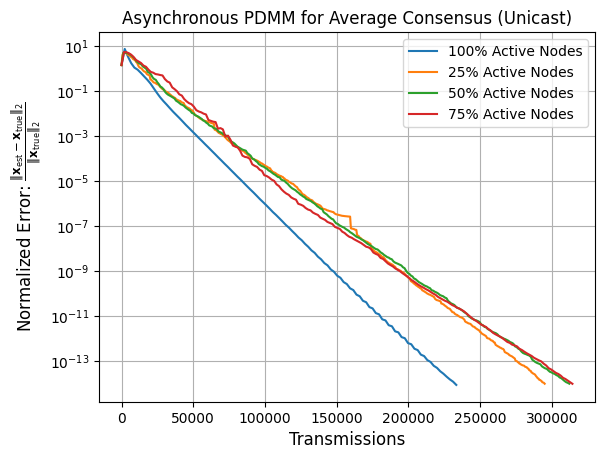

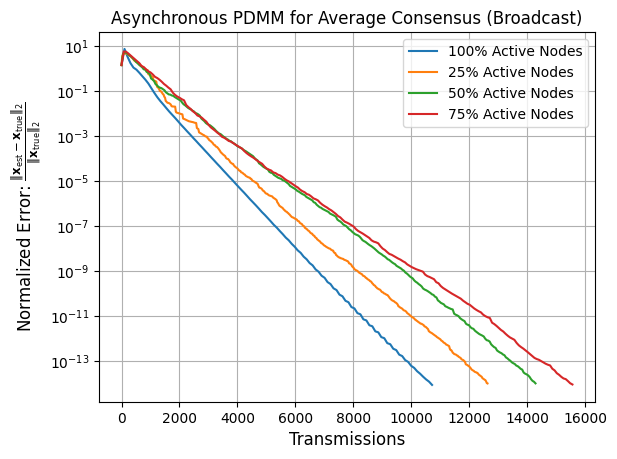

In [7]:
# Run Algorithms
error_vals_pu_an25, transmissions_pu_an25, x_pu_an25 = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = False, active_nodes=0.25)
error_vals_pu_an50, transmissions_pu_an50, x_pu_an50 = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = False, active_nodes=0.50)
error_vals_pu_an75, transmissions_pu_an75, x_pu_an75 = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = False, active_nodes=0.75)

error_vals_pb_an25, transmissions_pb_an25, x_pu_an25 = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = True, active_nodes=0.25)
error_vals_pb_an50, transmissions_pb_an50, x_pu_an50 = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = True, active_nodes=0.50)
error_vals_pb_an75, transmissions_pb_an75, x_pu_an75 = pdmm_average(adjacency_matrix, sensor_measurements, best_c, broadcast = True, active_nodes=0.75)

# Plotting
make_async_plots([error_vals_pu, error_vals_pu_an25, error_vals_pu_an50, error_vals_pu_an75],
              [transmissions_pu, transmissions_pu_an25, transmissions_pu_an50, transmissions_pu_an75], 
              "Asynchronous PDMM for Average Consensus (Unicast)",
              "pdmm_uni_async")
make_async_plots([error_vals_pb, error_vals_pb_an25, error_vals_pb_an50, error_vals_pb_an75],
              [transmissions_pb, transmissions_pb_an25, transmissions_pb_an50, transmissions_pb_an75], 
              "Asynchronous PDMM for Average Consensus (Broadcast)",
              "pdmm_broad_async")


**PDMM - Median Consensus**

In [8]:
c_vals = np.linspace(0.1, 1, 10)
num_transmissions = []
for c in c_vals:
    error_vals, transmissions, x = pdmm_median(adjacency_matrix, sensor_measurements, c, broadcast=False, num_iter=10000, err=1e-10)
    num_transmissions.append(transmissions[-1])
best_c = c_vals[np.argmin(num_transmissions)]
print("Best c value is:", np.round(best_c, 2))

fig = plt.figure()  
plt.plot(c_vals, num_transmissions, label='Number of Transmissions')
plt.grid(True)
plt.xlabel("c Value")
plt.ylabel("Number of Transmissions for Error = 1e-10")
plt.title("PDMM Median Consensus: c Value vs Transmissions")

KeyboardInterrupt: 

**PDMM - Median Consensus - Broadcast vs Unicast**

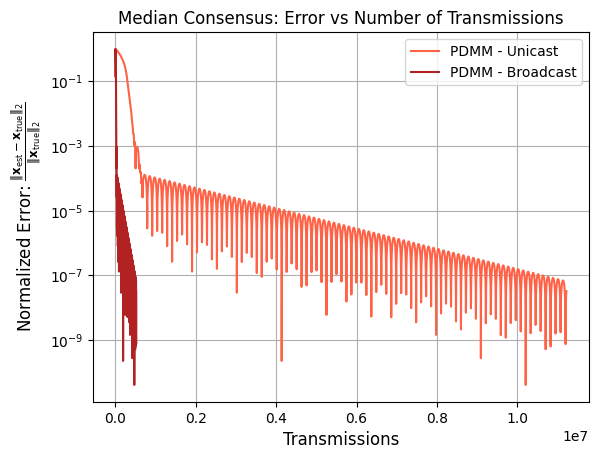

In [ ]:
error_vals_pu, transmissions_pu, x_pu = pdmm_median(adjacency_matrix, sensor_measurements, best_c, broadcast = False)
error_vals_pb, transmissions_pb, x_pb = pdmm_median(adjacency_matrix, sensor_measurements, best_c, broadcast = True)

fig = plt.figure()
plt.semilogy(transmissions_pu, error_vals_pu, label=f'PDMM - Unicast', color="tomato")
plt.semilogy(transmissions_pb, error_vals_pb, label=f'PDMM - Broadcast', color="firebrick")
plt.grid(True)
plt.xlabel("Transmissions")
plt.ylabel("Normalized Error")
plt.title("Median Consensus: Error vs Number of Transmissions")
plt.legend()
plt.savefig("figures/pdmm_median.png", bbox_inches='tight')

**PDMM - Median Consensus - Transmission Loss**

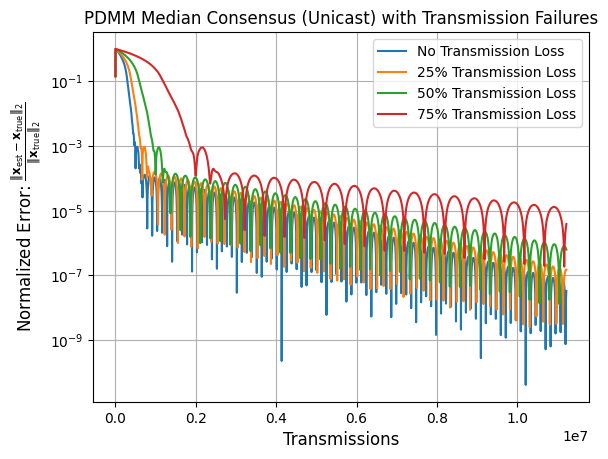

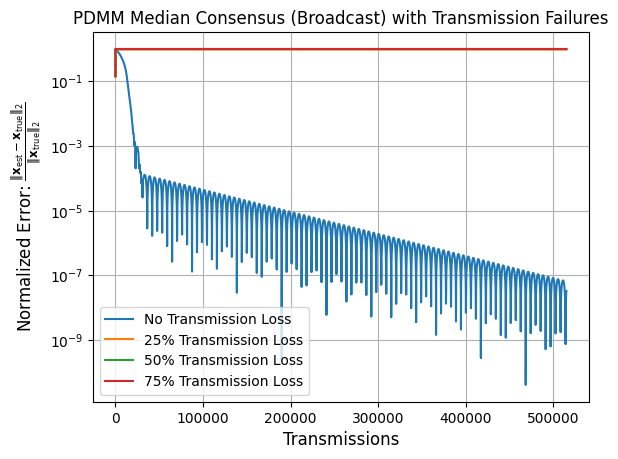

In [ ]:
error_vals_pu_tl25, transmissions_pu_tl25, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, broadcast = False, transmission_loss=0.25)
error_vals_pu_tl50, transmissions_pu_tl50, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, broadcast = False, transmission_loss=0.5)
error_vals_pu_tl75, transmissions_pu_tl75, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, broadcast = False, transmission_loss=0.75)

error_vals_pb_tl25, transmissions_pb_tl25, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, broadcast = True, transmission_loss=0.25)
error_vals_pb_tl50, transmissions_pb_tl50, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, broadcast = True, transmission_loss=0.5)
error_vals_pb_tl75, transmissions_pb_tl75, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, broadcast = True, transmission_loss=0.75)

make_tl_plots([error_vals_pu, error_vals_pu_tl25, error_vals_pu_tl50, error_vals_pu_tl75],
              [transmissions_pu, transmissions_pu_tl25, transmissions_pu_tl50, transmissions_pu_tl75], 
              "PDMM Median Consensus (Unicast) with Transmission Failures",
              "pdmm_median_uni_tf")
make_tl_plots([error_vals_pb, error_vals_pb_tl25, error_vals_pb_tl50, error_vals_pb_tl75],
              [transmissions_pb, transmissions_pb_tl25, transmissions_pb_tl50, transmissions_pb_tl75], 
              "PDMM Median Consensus (Broadcast) with Transmission Failures",
              "pdmm_median_broad_tf")

**Asynchronous PDMM for Median Consensus**

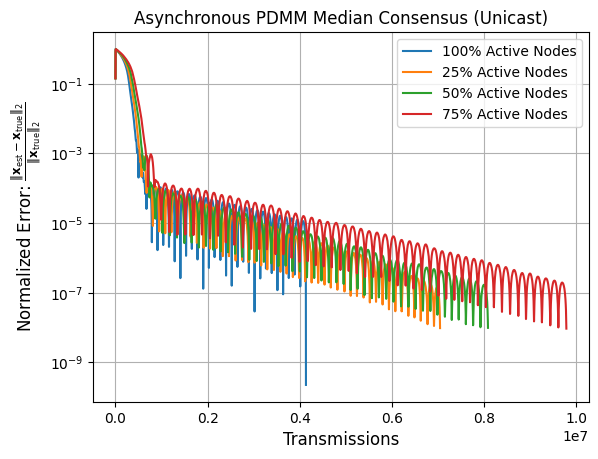

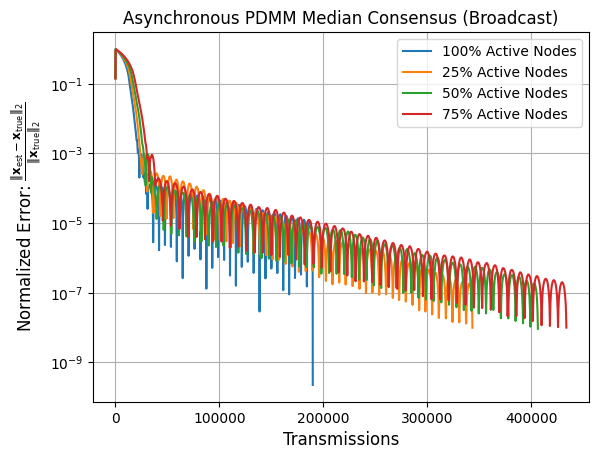

In [ ]:
error_vals_pu, transmissions_pu, x_pu = pdmm_median(adjacency_matrix, sensor_measurements, best_c, num_iter=20000, err=1e-8, broadcast = False)
error_vals_pb, transmissions_pb, x_pb = pdmm_median(adjacency_matrix, sensor_measurements, best_c, num_iter=20000, err=1e-8, broadcast = True)

error_vals_pu_an25, transmissions_pu_an25, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, num_iter=20000, err=1e-8, broadcast = False, active_nodes=0.25)
error_vals_pu_an50, transmissions_pu_an50, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, num_iter=20000, err=1e-8, broadcast = False, active_nodes=0.5)
error_vals_pu_an75, transmissions_pu_an75, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, num_iter=20000, err=1e-8, broadcast = False, active_nodes=0.75)

error_vals_pb_an25, transmissions_pb_an25, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, num_iter=20000, err=1e-8, broadcast = True, active_nodes=0.25)
error_vals_pb_an50, transmissions_pb_an50, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, num_iter=20000, err=1e-8, broadcast = True, active_nodes=0.5)
error_vals_pb_an75, transmissions_pb_an75, _ = pdmm_median(adjacency_matrix, sensor_measurements, best_c, num_iter=20000, err=1e-8, broadcast = True, active_nodes=0.75)

make_async_plots([error_vals_pu, error_vals_pu_an25, error_vals_pu_an50, error_vals_pu_an75],
              [transmissions_pu, transmissions_pu_an25, transmissions_pu_an50, transmissions_pu_an75], 
              "Asynchronous PDMM Median Consensus (Unicast)",
              "pdmm_median_uni_async")
make_async_plots([error_vals_pb, error_vals_pb_an25, error_vals_pb_an50, error_vals_pb_an75],
              [transmissions_pb, transmissions_pb_an25, transmissions_pb_an50, transmissions_pb_an75], 
              "Asynchronous PDMM Median Consensus (Broadcast)",
              "pdmm_median_broad_async")